<a href="https://colab.research.google.com/github/hansjang/Py_Radar/blob/main/%EB%8D%B0%EC%8B%B8%EB%9D%BC%EB%A9%B4Part7_P365.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!git clone https://github.com/ADPclass/ADP_book_ver01.git

Cloning into 'ADP_book_ver01'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 172 (delta 36), reused 55 (delta 19), pack-reused 81 (from 1)
Receiving objects: 100% (172/172), 17.54 MiB | 9.65 MiB/s, done.
Resolving deltas: 100% (49/49), done.


# 1. 시계열 분해

In [29]:
# 시계열 분해
import pandas as pd
import warnings

data = pd.read_csv('/content/ADP_book_ver01/data/arima_data.csv', names=['day', 'price'])
display(data.head())
display(data.info())
display(data.tail())

,day,price
0,2013-01-01,3794
1,2013-02-01,3863
2,2013-03-01,5190
3,2013-04-01,5783
4,2013-05-01,6298


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   day     60 non-null     object
 1   price   60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


None

,day,price
55,2017-08-01,8548
56,2017-09-01,7843
57,2017-10-01,7620
58,2017-11-01,7676
59,2017-12-01,5809


In [30]:
# 날짜형식 변환
data['day'] = pd.to_datetime(data['day'], format='%Y-%m-%d')
data.set_index('day', inplace=True)
display(data.head())
display(data.info())

,price
day,
2013-01-01,3794
2013-02-01,3863
2013-03-01,5190
2013-04-01,5783
2013-05-01,6298


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2013-01-01 to 2017-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   price   60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes


None

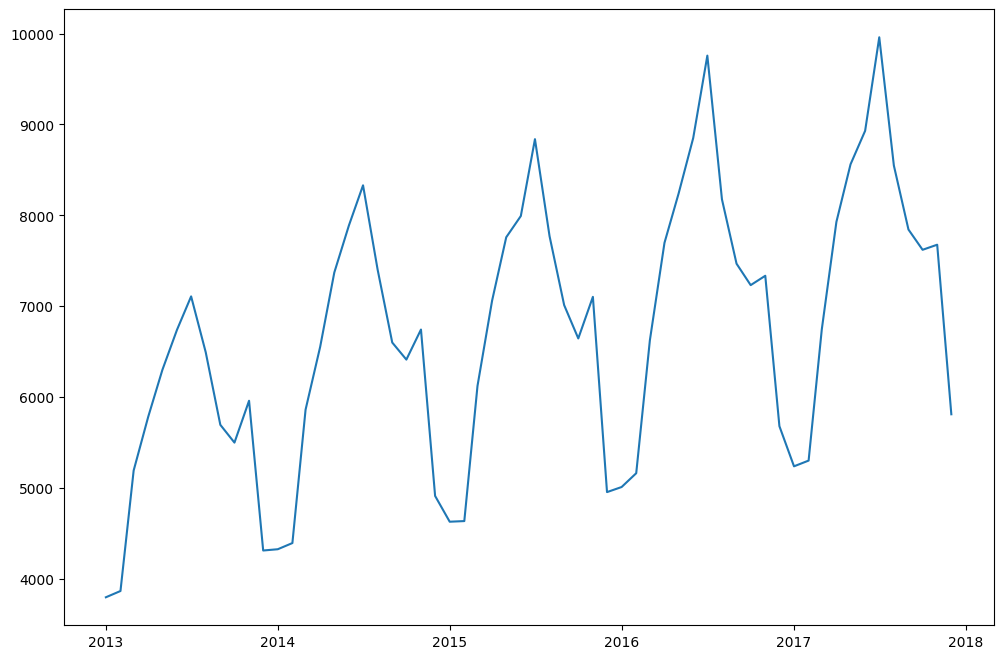

In [31]:
import matplotlib.pyplot as plt
plt.plot(data.index, data['price'])

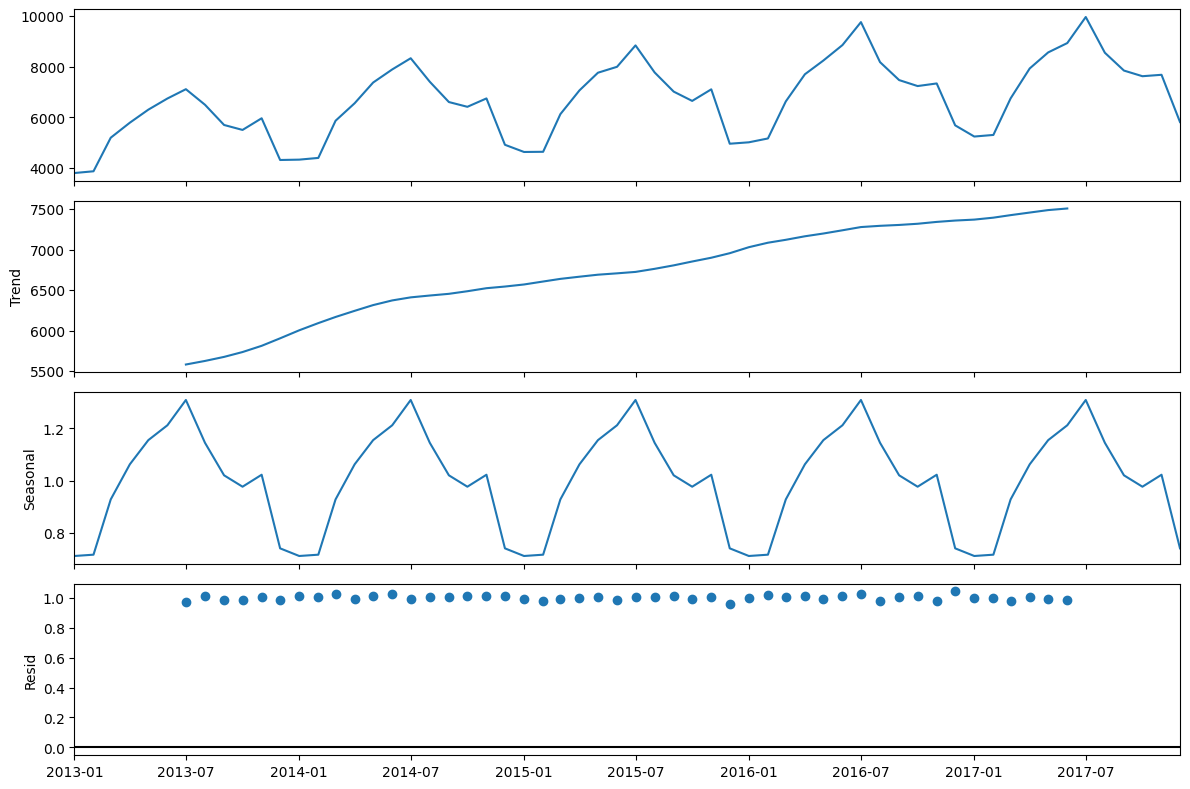

In [32]:
# 시계열 분해
from statsmodels.tsa.seasonal import seasonal_decompose

ts = data
result = seasonal_decompose(ts, model='multiplicative')
# 시간이 지날수록 변동성이 커지므로 multiplicative 모델 적용
plt.rcParams['figure.figsize'] = [12, 8]
result.plot()
plt.show()

seasonal_decompose 함수를 불러오고 시계열 분해를 해주었다. <br>
결과값을 보면 Trend와 Seasonal이 명확히 존재하며, 불규칙요인은 거의없음을 알 수 있다.

# 2. 정상성 검정 : ADF test

In [54]:
from statsmodels.tsa.stattools import adfuller

# Train, Test 데이터 구분
training = data[: "2016-12-01"]
test = data.drop(training.index)

adf = adfuller(training, regression = 'ct')
print('ADF Statistics: {}'.format(adf[0]))
print('p-value : {}'.format(adf[1]))

ADF Statistics: -1.9997199341327594
p-value : 0.601586330379429


ADF 테스트 결과, pvalue가 유의수준 0.05 보다 높으므로 해당 데이터는 정상성을 갖지 않다고 할 수 있다. 비정상 시계열을 정상 시계열로 변환시키기 위해서는 차분, 혹은 로그 변환을 해야 한다.

# 3. 정상성(Stationary) 변환

<Axes: xlabel='day'>

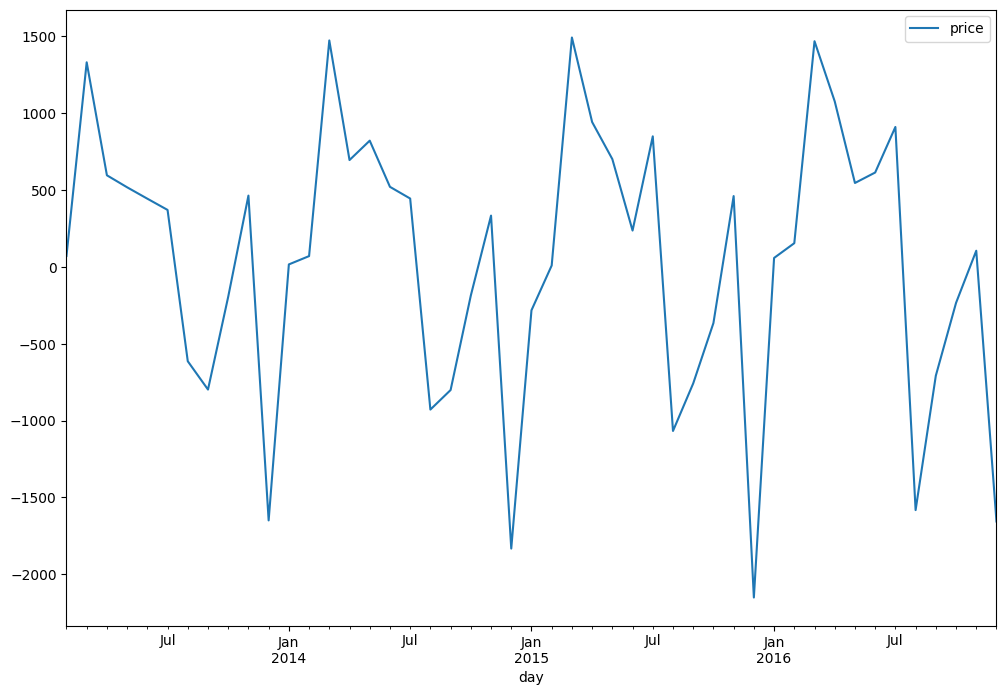

In [39]:
# 1차 차분
diff_data = training.diff(1).dropna()  # 1차 차분
diff_data.plot()

<Axes: xlabel='day'>

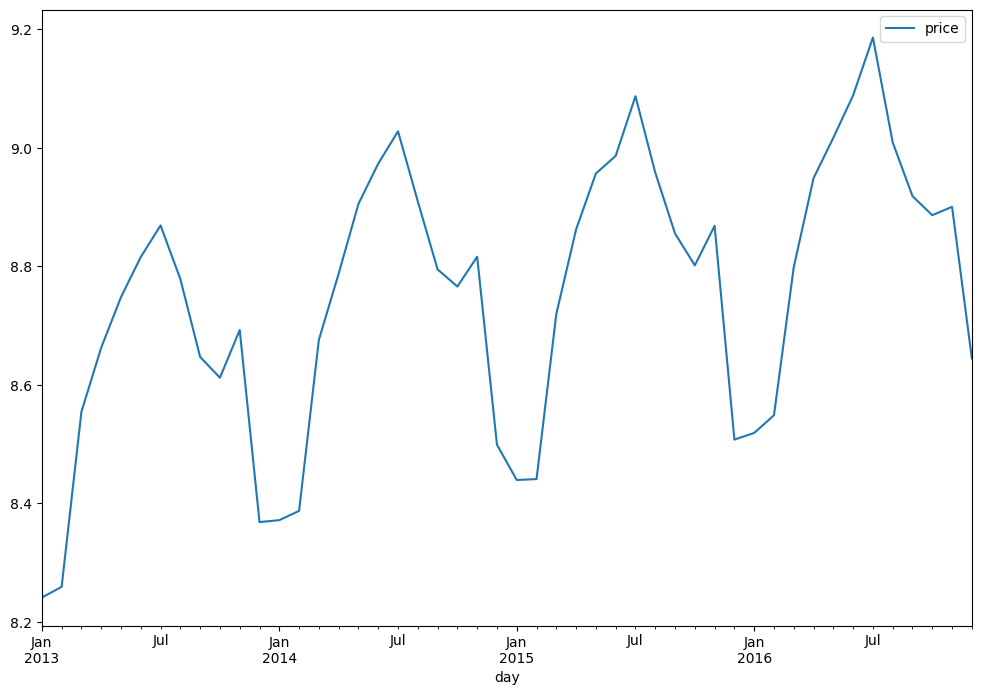

In [41]:
# 로그 변환
import numpy as np
log_data = np.log(training)
log_data.plot()

<Axes: xlabel='day'>

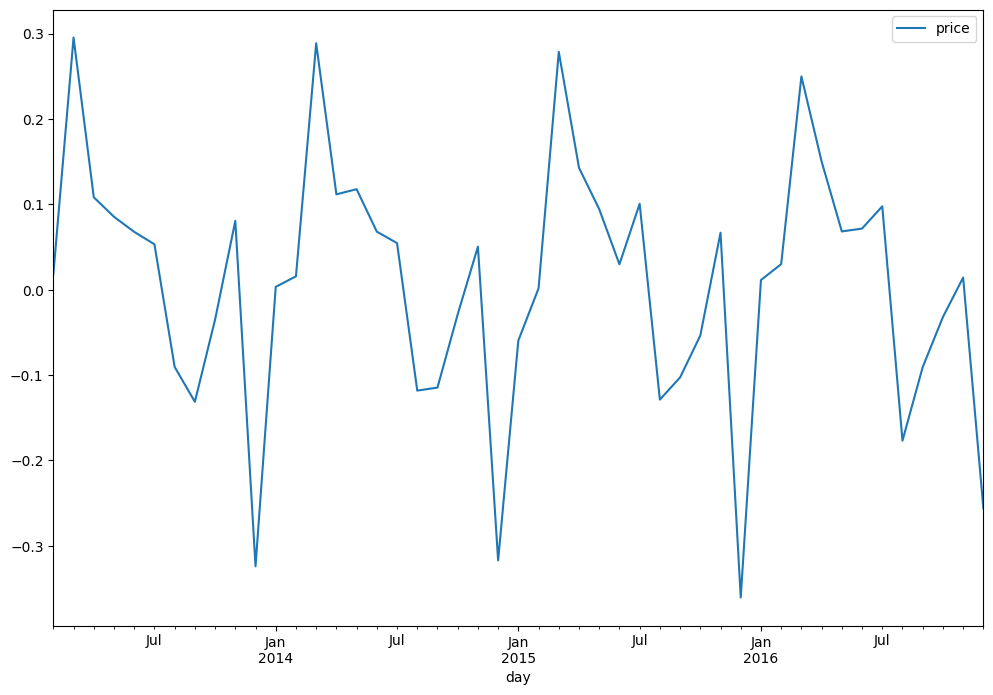

In [42]:
# 로그 변환 후 차분
import numpy as np
diff_log_data = np.log(training).diff(1).dropna()
diff_log_data.plot()

<Axes: xlabel='day'>

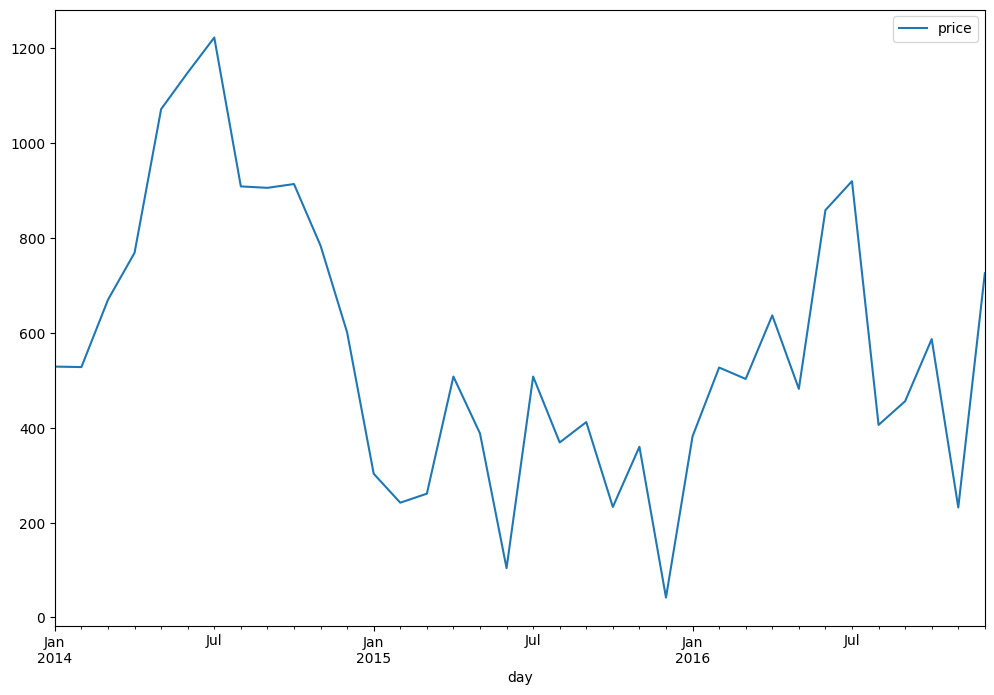

In [43]:
# 계절성 차분
seasonal_diff_data = training.diff(12).dropna()  # 계절성 차분(12개월 주기)
seasonal_diff_data.plot()

In [45]:
adf = adfuller(diff_data, regression = 'c')
print('ADF Statistics: {}'.format(adf[0]))
print('p-value : {}'.format(adf[1]))

adf = adfuller(log_data, regression = 'c')
print('ADF Statistics: {}'.format(adf[0]))
print('p-value : {}'.format(adf[1]))

adf = adfuller(diff_log_data, regression = 'c')
print('ADF Statistics: {}'.format(adf[0]))
print('p-value : {}'.format(adf[1]))

adf = adfuller(seasonal_diff_data, regression = 'c')
print('ADF Statistics: {}'.format(adf[0]))
print('p-value : {}'.format(adf[1]))

ADF Statistics: -12.094547576926397
p-value : 2.085160639961322e-22
ADF Statistics: -0.9580066129716956
p-value : 0.7682707831240536
ADF Statistics: -12.21341724284946
p-value : 1.1499573709235132e-22
ADF Statistics: -2.4550774551169297
p-value : 0.12679044019168428


adfuller의 regression default 값은 "c"이다. 1차 차분한 그래프가 트렌드를 보이지 않기에 매개변수는 "c"값을 적용하여 검정해야 한다. 검정 결과 p-value는 0.05보다 작으므로 귀무가설을 기각할 수 있다. 따라서 변환된 데이터는 정상시계열로 볼 수 있다.

# 3. ARIMA

In [48]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

model = ARIMA(training, order = (2, 1, 2))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                   48
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -375.875
Date:                Mon, 23 Sep 2024   AIC                            761.750
Time:                        11:35:32   BIC                            771.001
Sample:                    01-01-2013   HQIC                           765.231
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3167      0.190     -6.940      0.000      -1.689      -0.945
ar.L2         -0.3191      0.190     -1.675      0.094      -0.692       0.054
ma.L1          1.9700      0.243      8.121      0.000       1.495       2.445
ma.L2          0.9950      0.241      4.126      0.000       0.522       1.468
sigma2      4.453e+05   1.13e-06   3.93e+11      0.000    4.45e+05    4.45e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.38
Prob(Q):                              0.74   Prob(JB):                         0.83
Heteroskedasticity (H):               1.49   Skew:                            -0.21
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  6e+26. Standard errors may be unstable.
"""

In [50]:
import tabulate


# SARIMAX 출력
sarimax = res.summary().tables[0].data

# Coefficients 출력
coefficients = res.summary().tables[1].data

# 보기 좋게 테이블 출력
print(tabulate.tabulate(sarimax, headers="firstrow", tablefmt="grid"))
print(tabulate.tabulate(coefficients, headers="firstrow", tablefmt="grid"))

+------------------+------------------+-------------------------+----------+
| Dep. Variable:   | price            |   No. Observations:     | 48       |
+==================+==================+=========================+==========+
| Model:           | ARIMA(2, 1, 2)   | Log Likelihood          | -375.875 |
+------------------+------------------+-------------------------+----------+
| Date:            | Mon, 23 Sep 2024 | AIC                     | 761.750  |
+------------------+------------------+-------------------------+----------+
| Time:            | 11:38:35         | BIC                     | 771.001  |
+------------------+------------------+-------------------------+----------+
| Sample:          | 01-01-2013       | HQIC                    | 765.231  |
+------------------+------------------+-------------------------+----------+
|                  | - 12-01-2016     |                         |          |
+------------------+------------------+-------------------------+----------+

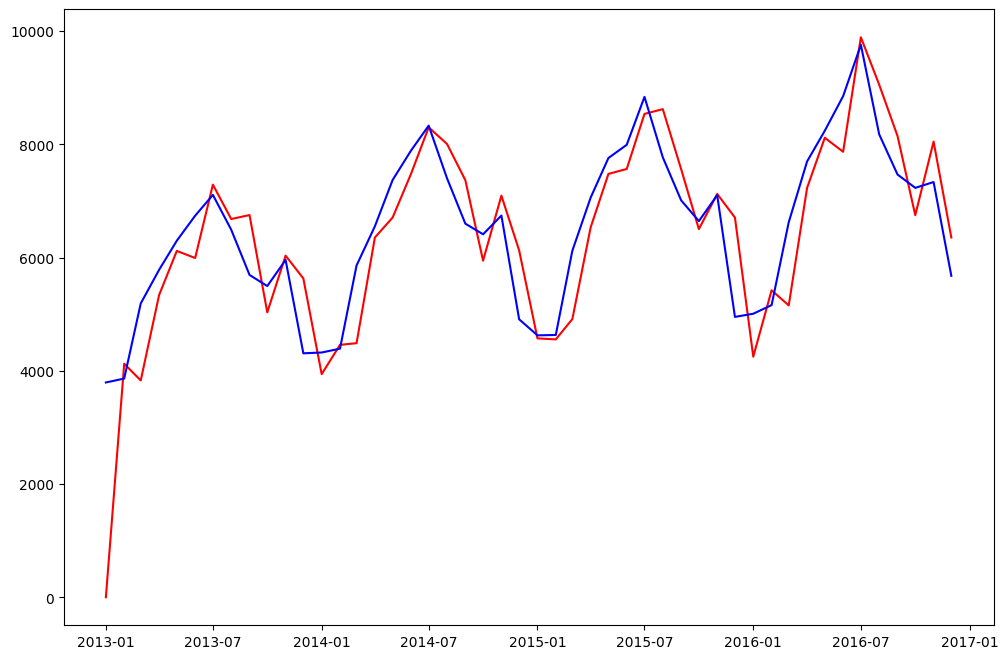

In [52]:
# 예측
plt.plot(res.predict(), color='r')
plt.plot(training, color='b')

In [55]:
# 학습데이터로부터 test 데이터 길이만큼 예측
forecast_data = res.forecast(steps=len(test), alpha=0.05)

pred_y = forecast_data
pred_y

,predicted_mean
2017-01-01,5830.560146
2017-02-01,5508.376754
2017-03-01,5883.921927
2017-04-01,5492.240862
2017-05-01,5888.140676
2017-06-01,5491.834906
2017-07-01,5887.329001
2017-08-01,5493.033200
2017-09-01,5886.010183
2017-10-01,5494.387346


In [56]:
test_y = test   # 실제 데이터
test_y

,price
day,
2017-01-01,5236
2017-02-01,5299
2017-03-01,6744
2017-04-01,7927
2017-05-01,8561
2017-06-01,8930
2017-07-01,9960
2017-08-01,8548
2017-09-01,7843


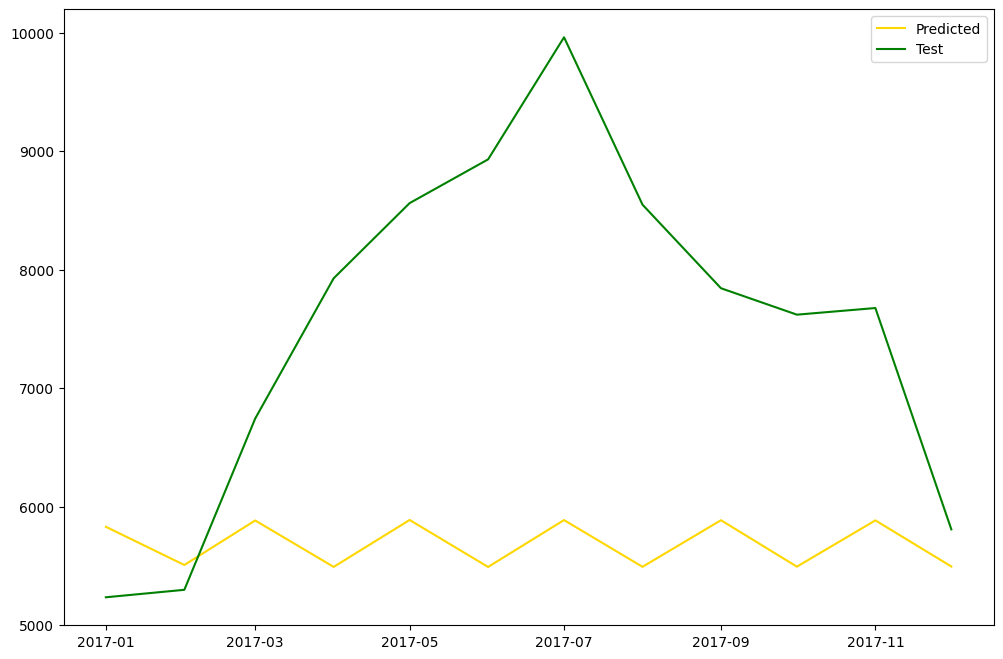

In [57]:
plt.plot(pred_y, color='gold', label='Predicted')  # 모델이 예상한 가격 그래프
plt.plot(test_y, color='green', label = 'Test')    # 실제 가격 그래프
plt.legend()
plt.show()

In [58]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print('r2_score : ', r2_score(test_y, pred_y))  # r2_score :  -1.6430396460564052
RMSE = np.sqrt(mean_squared_error(test_y, pred_y))
print('RMSE : ', RMSE)  # RMSE :  2302.26085893071

r2_score :  -1.6430396460564052
RMSE :  2302.26085893071


R2 값이 음수가 나온다는 것은 해당 모델의 정확도가 매우 낮다는 것이다. 이는 ARIMA의 경우 긴 값을 예측할 때, 표본평균으로 회귀하려는 경향 때문에 R2 값이 작게 나오는 것으로 판단된다. 계절성이 있는 경우 SARIMA 모델을 사용하는 것이 좋다.

# 4. SARIMA

계절성까지 고려한 ARIMA 모델이다

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA 모델 정의
model = SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, s))

# 모델 학습
results = model.fit()

# 모델 결과 출력
print(results.summary())

# 예측
pred = results.forecast(steps=12)
print(pred)


In [64]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA 모델 정의
model = SARIMAX(training, order = (2, 1, 2),
                seasonal_order = (1, 1, 1, 12))

# 모델 학습
results = model.fit()

# 모델 결과 출력
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                price   No. Observations:                   48
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -236.703
Date:                              Mon, 23 Sep 2024   AIC                            487.406
Time:                                      12:33:28   BIC                            498.294
Sample:                                  01-01-2013   HQIC                           491.165
                                       - 12-01-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0631      0.281     -3.784      0.000      -1.614      -0.512
ar.L2         -0.94

In [65]:
# 학습데이터로부터 test 데이터 길이만큼 예측
forecast_data = results.forecast(steps=len(test), alpha=0.05)

pred_y = forecast_data
pred_y

,predicted_mean
2017-01-01,5531.689086
2017-02-01,5595.631396
2017-03-01,7224.737773
2017-04-01,8174.399310
2017-05-01,8667.635638
2017-06-01,9330.444622
2017-07-01,10140.274144
2017-08-01,8646.129814
2017-09-01,8056.760943
2017-10-01,7648.525955


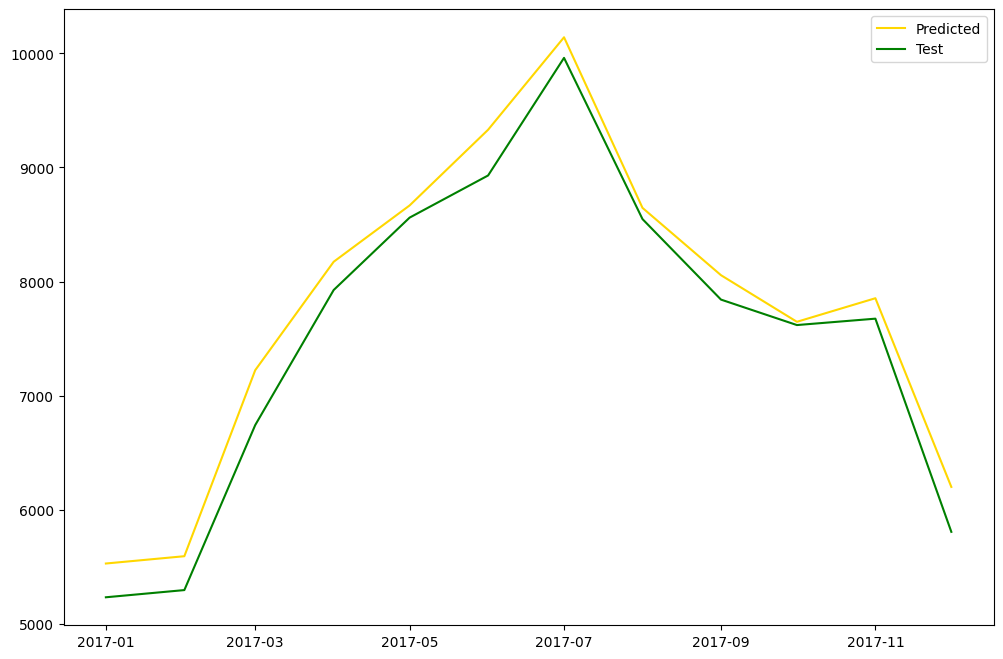

In [68]:
plt.plot(pred_y, color='gold', label='Predicted')  # 모델이 예상한 가격 그래프
plt.plot(test_y, color='green', label = 'Test')    # 실제 가격 그래프
plt.legend()
plt.show()

In [67]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print('r2_score : ', r2_score(test_y, pred_y))  # r2_score :  0.9619803323181157
RMSE = np.sqrt(mean_squared_error(test_y, pred_y))
print('RMSE : ', RMSE)  # RMSE :  276.1257124776541

r2_score :  0.9619803323181157
RMSE :  276.1257124776541


In [59]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.5 MB/s eta 0:00:00


In [60]:
from pmdarima import auto_arima

auto_model = auto_arima(training, start_p = 0, d = 1, start_q = 0,
                        max_p = 3, max_q = 3,
                        start_P = 0, start_Q = 0,
                        max_P = 3, max_Q = 3, m = 12,
                        seasonal = True, information_criterion = 'aic',
                        trace = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=481.846, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=482.652, Time=0.41 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=482.466, Time=0.68 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=483.637, Time=0.27 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=483.669, Time=0.59 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=3.77 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=481.031, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=482.740, Time=1.19 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=482.616, Time=0.09 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=482.682, Time=0.18 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=480.687, Time=0.06 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=482.403, Time=0.19 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=48